### Predict DJ Moore Movement

CNN to create a spatial repersentation of the context data

Inject Context Embedding & Player Embeddings, early fusion for the player context 
and before the fully connected layer for the gloabl context. Use the CNN as a form of encoder, use a transpose CNN to find loss function

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

os.chdir('C:/Users/dalto/OneDrive/Pictures/Documents/Emory/NFL Lab/data')
df = pd.read_csv('2023_tracking.csv')
df = df.dropna()

In [2]:
play_ids = df['play_id_n'].unique()[:1500]
df = df[df['play_id_n'].isin(play_ids)]

#### 2d grid for cnn

In [3]:
def pixel_map(player_data, grid_width=121, grid_height=55, sigma=.8):
    
    # three channels, one for offense, one for defense, one for ball location, one for player to predict
    pixel_map = np.zeros((4, grid_height, grid_width), dtype=np.float32)
    
    x_vals = player_data['x'].values
    y_vals = player_data['y'].values
    
    for i, (x, y) in enumerate(zip(x_vals, y_vals)):
        x_min = max(0, int(np.floor(x - 2*sigma)))
        x_max = min(grid_width, int(np.ceil(x + 2*sigma)) + 1)
        y_min = max(0, int(np.floor(y - 2*sigma)))
        y_max = min(grid_height, int(np.ceil(y + 2*sigma)) + 1)
        
        for xi in range(x_min, x_max):
            for yi in range(y_min, y_max):
                dist_sq = (xi - x)**2 + (yi - y)**2
                weight = np.exp(-dist_sq / (2 * sigma**2))
                if player_data.iloc[i]['player_to_predict'] == True:
                    pixel_map[2, yi, xi] += weight 
                elif player_data.iloc[i]['player_side'] == 'Offense':
                    pixel_map[0, yi, xi] += weight
                elif player_data.iloc[i]['player_side'] == 'Defense':
                    pixel_map[1, yi, xi] += weight
                
    
    ball_x = player_data['ball_land_x'].iloc[0]
    ball_y = player_data['ball_land_y'].iloc[0]
    
    ball_x_min = max(0, int(np.floor(ball_x - 2*sigma)))
    ball_x_max = min(grid_width, int(np.ceil(ball_x + 2*sigma)) + 1)
    ball_y_min = max(0, int(np.floor(ball_y - 2*sigma)))
    ball_y_max = min(grid_height, int(np.ceil(ball_y + 2*sigma)) + 1)
    
    for xi in range(ball_x_min, ball_x_max):
        for yi in range(ball_y_min, ball_y_max):
            dist_sq = (xi - ball_x)**2 + (yi - ball_y)**2
            weight = np.exp(-dist_sq / (2 * sigma**2))
            pixel_map[3, yi, xi] += weight
    
    return pixel_map

testing one play

In [109]:
df_play_id = df[df['play_id_n'] == 456]
df_grids_t= df_play_id.groupby(['play_id_n','frame_id']).apply(lambda x: pd.Series({'grid': pixel_map(x)}))

C:\Users\dalto\AppData\Local\Temp\ipykernel_8904\3215127569.py:2: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_grids_t= df_play_id.groupby(['play_id_n','frame_id']).apply(lambda x: pd.Series({'grid': pixel_map(x)}))


grid for all plays

In [ ]:
df_grids = df.groupby(['play_id_n','frame_id']).apply(lambda x: pd.Series({'grid': pixel_map(x)}))

In [ ]:
df_grids = df_grids.reset_index()
df_grids = df_grids.sort_values(['play_id_n', 'frame_id'])

plot cords

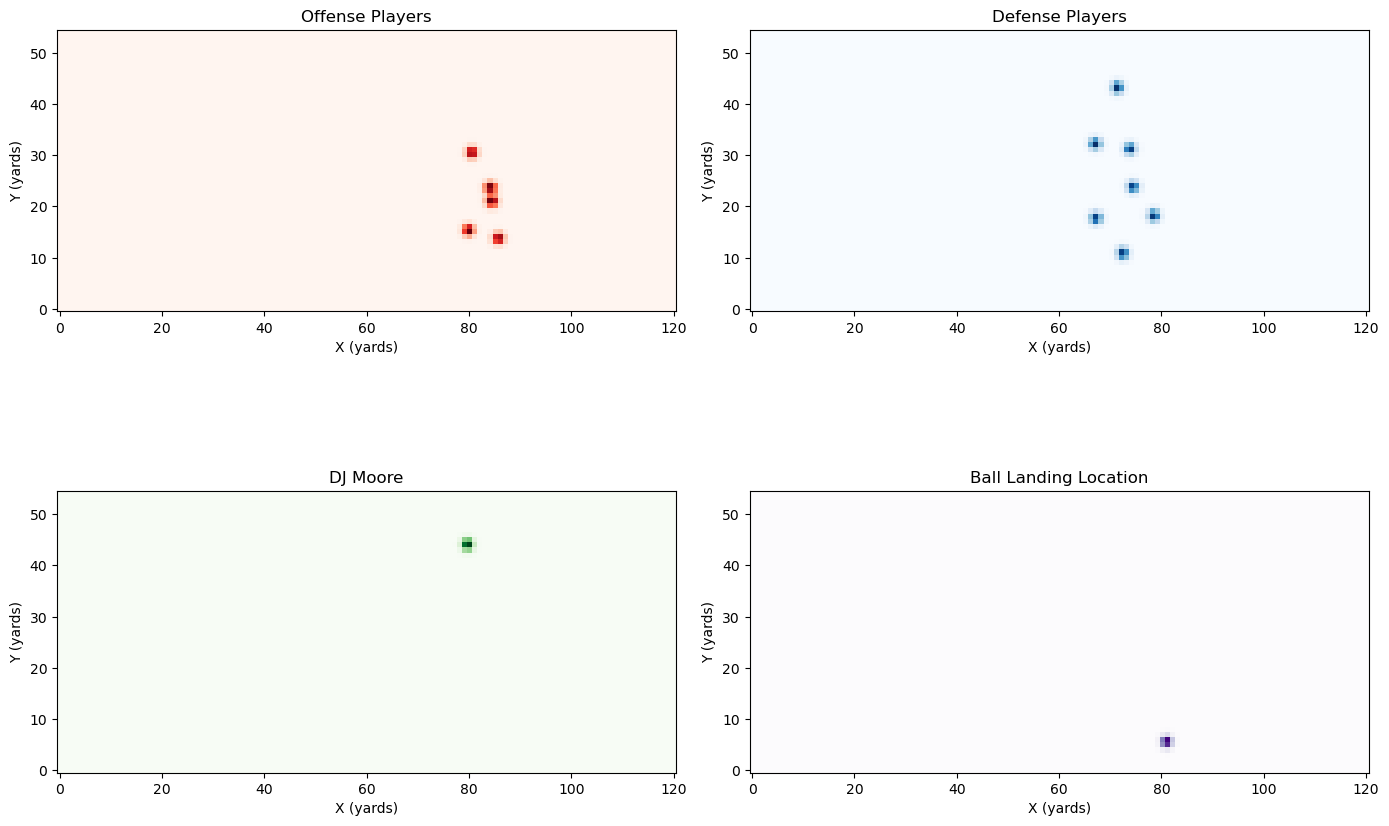

In [ ]:
sample_grid = df_grids_t['grid'].iloc[4]

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

axes[0, 0].imshow(sample_grid[0], origin='lower', cmap='Reds')
axes[0, 0].set_title('Offense Players')
axes[0, 0].set_xlabel('X (yards)')
axes[0, 0].set_ylabel('Y (yards)')

axes[0, 1].imshow(sample_grid[1], origin='lower', cmap='Blues')
axes[0, 1].set_title('Defense Players')
axes[0, 1].set_xlabel('X (yards)')
axes[0, 1].set_ylabel('Y (yards)')

axes[1, 0].imshow(sample_grid[2], origin='lower', cmap='Greens')
axes[1, 0].set_title('Player to Predict')
axes[1, 0].set_xlabel('X (yards)')
axes[1, 0].set_ylabel('Y (yards)')

axes[1, 1].imshow(sample_grid[3], origin='lower', cmap='Purples')
axes[1, 1].set_title('Ball Landing Location')
axes[1, 1].set_xlabel('X (yards)')
axes[1, 1].set_ylabel('Y (yards)')

plt.tight_layout()
plt.show()


In [ ]:
df_grids.to_pickle("grids_1500.pkl")

#### CNN, Transformer

Create cnn, transformer encoder, and decoder to predict positon. At this point, we do not need to build a complex decoder it can just be a feedforward linear network. 

In [ ]:
import torch
import torch.nn as nn 
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
import gc
from transformers import get_cosine_schedule_with_warmup
df_grids = pd.read_pickle("grids_1500.pkl")
torch.manual_seed(26)

c:\Users\dalto\anaconda3\envs\nflLab\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cnn to downsample heatmap

In [18]:
class CNN_DownSample(nn.Module):
    def __init__(self):
        super().__init__()
        # using stride rather than max pooling preforms better as max pooling tends to compress feat. too much.
        self.heatmap_encoder = nn.Sequential(
            nn.Conv2d(in_channels=4, out_channels=16, kernel_size=3, stride = 2, padding=1),
            nn.BatchNorm2d(16), # normalize var and mean
            nn.ReLU(inplace=True), # preforms better on average idk if itll make a difference in this application

            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride = 2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride = 2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        
    def forward(self, x):
        x = self.heatmap_encoder(x)
        return x
    

attention layer

In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, nhead, mask, dropout=0.15):
        super().__init__() # inhert from parent class
        
        if d_model % nhead != 0:
            raise ValueError(f"d_model ({d_model}) must be divisible by nhead ({nhead})")
            
        self.d_model = d_model # dimension of model
        self.nhead = nhead # number of attention heads, multi headed 
        self.head_dim = d_model // nhead 

        # create key query and values
        self.qkv_proj = nn.Linear(d_model, 3 * d_model)
        # learn context as a product of the attention heads
        self.out_proj = nn.Linear(d_model, d_model)
        # dropout as a form of regularzation
        self.dropout = nn.Dropout(dropout)
        # scaling function
        self.scale = self.head_dim ** -0.5

    def forward(self, x, mask=None):
        B, L, _ = x.shape # batch and length
        
        # create q, k, v values | init just random matrix mults, learned parameter
        qkv = self.qkv_proj(x)
        
        # split key, query, and value vectors into diff pares
        q, k, v = qkv.chunk(3, dim=-1)
        
        # transpose the matrix so that batch and nhead are treated as batches and self attention is calculated from there
        q = q.view(B, L, self.nhead, self.head_dim).transpose(1, 2)
        k = k.view(B, L, self.nhead, self.head_dim).transpose(1, 2)
        v = v.view(B, L, self.nhead, self.head_dim).transpose(1, 2)
    
        # scaled dot product, scale so values arent 0 or 1 
        scores = torch.matmul(q, k.transpose(-2, -1)) * self.scale # matrix mult
        
        # set masked values to -inf so softmax does not "give" attention to them
        if mask is not None:
            mask = mask.unsqueeze(1).unsqueeze(1) 
            mask = mask.expand(B, self.nhead, L, L) 
            scores = scores.masked_fill(mask == 0, -1e9)
            
            
        # softmax to give attention weights to each token
        attn_weights = torch.softmax(scores, dim=-1)
        
        # drop some weights 
        attn_weights = self.dropout(attn_weights)
        
        # context vector for a given input sequence
        context = torch.matmul(attn_weights, v) 
        
        # transpose so the matrix is in the correct size to be concatinated
        context = context.transpose(1, 2).contiguous().view(B, L, self.d_model)
        
        # "combine" the outputs from the head to one general vector
        output = self.out_proj(context)
        
        return output

transformer block

In [ ]:
class TransformerBlock(nn.Module):
    def __init__(self, d_model, nhead=6, mask=None, dropout=0.15):
        super(TransformerBlock, self).__init__()
        # self attention class definied above
        self.self_attn = MultiHeadAttention(d_model=d_model, nhead=nhead, dropout=dropout, mask=mask)
        
        # feed forward network for each token
        self.feed_forward = nn.Sequential(
            nn.Linear(64, 128),
            nn.LeakyReLU(),
            nn.Dropout(dropout), # to combat overfitting
            nn.Linear(128, 64)
        )

        # normilzations so values are between 0-1, learned gamma and beta parameters
        # to shift center and var for values.
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        
        # standard dropout
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask):
        residual = x
        # normalized pre attention layer, gradients flow black directly without the normalizing effecting x values
        norm_x = self.norm1(x)
        # self attention
        attn_output = self.self_attn(norm_x, mask)
        # adding residual back to self attention
        x = residual + self.dropout(attn_output)
        
        residual = x
        # normalize values
        # we do so because over the amount of layers scale can get distorted, lead to super big or small values
        norm_x = self.norm2(x) 
        # basic fcn
        ff_output = self.feed_forward(norm_x)
        # adding residual back so that the gradient can flow directly back.
        # adds a 1 + terms to gradients, helps solve the vanishing gradients problem
        x = residual + self.dropout(ff_output)
        
        return x

In [ ]:
# use sinusoidal functions, simpler than learned values and generalizes better to unseen parameters
class PositionalEncoding(nn.Module):
    def __init__(self, embed_size, dropout, max_length=5000):
        super(PositionalEncoding, self).__init__()
        # droput
        self.dropout = nn.Dropout(p=dropout)

        # create matrix
        pe = torch.zeros(max_length, embed_size)
        
        # position tensor shape
        position = torch.arange(0, max_length, dtype=torch.float).unsqueeze(1)
        
        # div_term tensor shape
        div_term = torch.exp(torch.arange(0, embed_size, 2).float() * (-torch.log(torch.tensor(10000.0)) / embed_size))
        
        # apply sin to even indices
        pe[:, 0::2] = torch.sin(position * div_term)
        # apply cos to odd indices
        if embed_size % 2 == 1:
            pe[:, 1::2] = torch.cos(position * div_term[:-1])
        else:
            pe[:, 1::2] = torch.cos(position * div_term)
        
        # register as buffer so it moves with model to device
        self.register_buffer('pe', pe)

    def forward(self, x):
        pe_slice = self.pe[:x.size(1), :].to(x.device)
        x = x + pe_slice
        return self.dropout(x)

class TransEncoder(nn.Module):
    def __init__(self, input_dim, embed_size, num_layers, device, dropout, mask, max_length):
        super(TransEncoder, self).__init__()
        self.embed_size = embed_size 
        self.device = device
        # learned matrix projection
        self.input_projection = nn.Linear(input_dim, embed_size)
        # postional encoding 
        self.position_encoding = PositionalEncoding(embed_size, dropout, max_length)
        # layers of model, just stacked encoding layer
        self.layers = nn.ModuleList(
            [
                TransformerBlock(
                    embed_size,
                    mask=mask,
                    nhead=6, # number of attention heads
                    dropout=dropout
                )
                for _ in range(num_layers)
            ]
        )

    def forward(self, x, mask):
        # input layer matrix mult
        projected_input = self.input_projection(x)
        # position encodings
        out = self.position_encoding(projected_input)
        # pass through transformer block
        for layer in self.layers:
            out = layer(out, mask)

        return out


postion decoder

In [ ]:
class AdditiveAttentionPooling(nn.Module):
    def __init__(self, embed_size):
        super().__init__()
        # learned pooling, apply diffrent weights to diff frames
        self.attention = nn.Sequential(
            nn.Linear(64, 128),
            nn.Tanh(), # over relu because between -1, 1 and is more stable
            nn.Linear(128, 1)
        )
    
    def forward(self, x):
        # raw attention weights 
        attn_scores = self.attention(x) 
        # softmax and normalize
        attn_weights = torch.softmax(attn_scores, dim=1) 
        # frame values based on attention weights
        pooled = torch.sum(x * attn_weights, dim=1) 
        # return back to matrix 
        return pooled, attn_weights.squeeze(-1) 

In [ ]:
class PositionDecoder(nn.Module):
    def __init__(self, dropout=0.15):
        super(PositionDecoder, self).__init__()
        # addaptive pooling, learn the importances of diffrent frames, 
        self.global_pool = AdditiveAttentionPooling(embed_size=64)
        # fcnn in funnel shape, prob need to adjust this when actually training
        self.decoder = nn.Sequential(
            nn.Linear(64, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout * 1.5),

            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),

            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout * .5),

            nn.Linear(64, 2)
        )
    
    def forward(self, encoded_sequence):
        # pooling across all steps in input sequence
        pooled, _ = self.global_pool(encoded_sequence) 
        # predict final position
        position = self.decoder(pooled) 
        
        return position

In [ ]:
class DJmoorePOS(nn.Module):
    def __init__(self, embed_size, num_layers, dropout, mask, dev='cuda'):
        super().__init__()
        # downsample cnn
        self.cnn = CNN_DownSample()
        # cnn output size
        cnn_output_size = 64 * 7 * 16
        # transformer encoder module
        self.encoder = TransEncoder(
            input_dim=cnn_output_size,
            embed_size=embed_size,
            num_layers=num_layers,
            device=dev,
            mask=mask,
            dropout=dropout,
            max_length=100
        )
        # decoder, predict output
        self.decoder = PositionDecoder(dropout=dropout)
    def forward(self, heatmap_sequence):
        # batch size, seq
        batch_size, seq_len = heatmap_sequence.shape[:2]
        # downsample each heatmap through the cnn
        cnn_features = []
        for t in range(seq_len):
            # select all rows and the t col
            frame = heatmap_sequence[:, t]
            # extract features from cnn
            features = self.cnn(frame)
            # keep 0dim, flatten all other features (mult) together
            features = features.flatten(1)
            # save extracted features
            cnn_features.append(features)
        # stack extracted features into a sequence
        sequence_features = torch.stack(cnn_features, dim=1)
        # attention mask, not needed for now because we are 
        # only prediciting the one frame
        mask = torch.ones(batch_size, seq_len, device=heatmap_sequence.device)
        # encoding sequence
        encoder = self.encoder(sequence_features, mask)
        # predict positon
        position = self.decoder(encoder)
        # return position
        return position


In [ ]:
def train_sequences(df_grids, max_seq):
    sequences = []
    targets = []
    
    # get players to predict postions
    player_positions = df[df['play_to_predict'] == 'True'][['play_id_n', 'frame_id', 'x', 'y']].set_index(['play_id_n', 'frame_id'])

    # loop through every play
    for play_id in df_grids['play_id_n'].unique():
        play_data = df_grids[df_grids['play_id_n'] == play_id].sort_values('frame_id')
            # padding with sequence length less than max
        if len(play_data) < max_seq:
            grids = [torch.from_numpy(grid).float() for grid in play_data['grid']]
            sequence = torch.stack(grids, dim=0)
            
            noise = torch.randn_like(sequence) * 0.0001
            sequence = sequence + noise
            
            # out of dist value
            padding_needed = max_seq - len(play_data)
            padding = torch.full((padding_needed, 4, 55, 121), -1.0)
            sequence = torch.cat([sequence, padding], dim=0)
            
            # dj moore target frame, last frame
            target_frame = play_data.iloc[-1]['frame_id']
            try:
                player_pos = player_positions.loc[(play_id, target_frame), ['x', 'y']]
                player_x = float(player_pos['x']) / 120
                player_y = float(player_pos['y']) / 53.3
                sequences.append(sequence)
                targets.append(torch.tensor([player_x, player_y], dtype=torch.float32))
            except KeyError:
                continue

    if len(sequences) == 0:
        return None, None
    
    sequences = torch.stack(sequences, dim = 0)
    targets = torch.stack(targets, dim = 0)
    return sequences, targets

In [ ]:
# training loop
def train(model, train_loader, val_loader, loss_func, optimizer, scheduler, epochs):
    # losses
    train_losses = []
    # early stopping
    es = np.inf
    es_count = 0
    # training rounds
    for epoch in range(epochs):
        # set to traing mode
        model.train()
        # loss and batch count
        epoch_loss = 0
        batches = 0
        # load training sequences and targets
        for batch_sequence, batch_targets in train_loader:
            batch_sequence = batch_sequence.to('cuda')
            batch_targets = batch_targets.to('cuda')
            # zero gradient
            optimizer.zero_grad()
            # forward pass
            preds = model(batch_sequence) # predicted value
            loss = loss_func(preds, batch_targets) # loss
            # backprop time (as an aside its so cool it works so effectively being a realtively simple concept)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1) # prevent exploding gradients
            optimizer.step()

            # batch loss calcs
            epoch_loss += loss.item() * batch_sequence.size(0)
            batches += batch_sequence.size(0)

        # epoch loss on train set
        avg_loss = epoch_loss / batches

        val_loss = 0
        val_batches = 0

        # val loss
        model.eval() # set to eval mode
        with torch.no_grad(): 
            for val_seq, val_targ in val_loader:
                # move to cuda
                val_seq = val_seq.to('cuda')
                val_targ = val_targ.to('cuda')
                # val_x, val_y
                val_preds = model(val_seq)
                # val loss
                val_seq_loss = loss_func(val_preds, val_targ)
                val_loss += val_seq_loss.item() * val_seq.size(0) 
                val_batches += val_seq.size(0)
        # loss 
        val_loss = val_loss / val_batches

        # early stopping
        if val_loss < es:
            es = val_loss
            es_count = 0
        else:
            es_count += 1

        # save train loss, update LR 
        train_losses.append(avg_loss)
        scheduler.step(val_loss)

        if epoch % 5 == 0:
            print(f'epoch: {epoch} train_loss: {avg_loss} val_loss:{val_loss}')
        
        if es_count >= 25:
            break

    return train_losses

# predict final positon
def predict(model, sequence):
    # torch eval mode
    model.eval()
    # do not compute gradients
    with torch.no_grad():
        # adds dim if batch dim is not present
        if sequence.dim() == 4: 
            sequence = sequence.unsqueeze(0)
        # move to gpu
        sequence = sequence.to('cuda')
        # prediction
        prediction = model(sequence)
        x, y = prediction[0].cpu().numpy() # move to cpu, convert from tesnor to numpy 
        # undo scaling
        # x = x * 120
        # y = y * 53.3
    
    return x, y

#### Training

In [49]:
print(torch.cuda.is_available())
torch.cuda.empty_cache()
gc.collect()

True


4104

In [45]:
import torch.nn.functional as F

class VarianceRegularizedLoss(nn.Module):
    def __init__(self, alpha=1.0, beta=0.1):
        super().__init__()
        self.alpha = alpha  
        self.beta = beta    
        
    def forward(self, predictions, targets):
        # mse loss
        mse_loss = F.mse_loss(predictions, targets)
        
        # match the varience between predection and target
        pred_var = torch.var(predictions, dim=0)
        target_var = torch.var(targets, dim=0)
        
        # penalize low varience in results 
        variance_penalty = F.mse_loss(pred_var, target_var)
        
        return self.alpha * mse_loss + self.beta * variance_penalty

In [ ]:
model = DJmoorePOS(embed_size=64, num_layers=8, mask=None, dropout=0.15, dev="cuda")
# move model to cuda
model = model.to("cuda")
# standard loss function
loss_fun = VarianceRegularizedLoss(alpha=1, beta=0.15)
# adamW > adam, bc of the proper application of weight decay
opti = torch.optim.AdamW(model.parameters(), lr = 0.0001, weight_decay=0.001)
# LR scheduler
lr_schedule =  get_cosine_schedule_with_warmup(opti, num_warmup_steps=20, num_training_steps=500)

In [ ]:
seq, targ = train_sequences(df_grids, max_seq=81) 

X_train, X_test, y_train, y_test = train_test_split(seq, targ, test_size=0.3, random_state=26,shuffle=True)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=26, shuffle = True)

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
val_dataset = TensorDataset(X_val, y_val)

train_load = DataLoader(train_dataset, batch_size = 64, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size = 64, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size = 64, shuffle=False)

In [47]:
# test to make sure working properly
test = seq[1]
pred_x, pred_y = predict(model, test)

In [ ]:
train(model=model, train_loader=train_load, val_loader = val_loader, 
      loss_func=loss_fun, optimizer=opti,scheduler=lr_schedule, epochs=500)

In [18]:
def eval_loop(model, test_loader, loss_fun):
    model.eval()
    total_loss = 0
    total_sample = 0
    all_pred = []
    all_target = []
    
    with torch.no_grad():
        for batch_seq, batch_targ in test_loader:
            batch_seq = batch_seq.to('cuda')
            batch_targ = batch_targ.to('cuda')

            preds = model(batch_seq)
            loss = loss_fun(preds, batch_targ)

            total_loss += loss.item() * batch_seq.size(0) 
            total_sample += batch_seq.size(0)
            
            all_pred.append(preds.cpu())
            all_target.append(batch_targ.cpu())

    avg_test_loss = total_loss / total_sample
    all_pred = torch.cat(all_pred, dim = 0)
    all_target = torch.cat(all_target, dim=0)

    return avg_test_loss, all_pred, all_target

In [20]:
loss, pred, target = eval_loop(model=model, test_loader=test_loader, loss_fun=loss_fun)
print(loss)

14.947563098027157
